# Unsupervised Benchmarking

## Importing libraries

In [1]:
## General
from __future__ import print_function 
import sys 
import pandas as pd
import numpy as np
from base64 import b64encode 
import types 

## Metrics

from sklearn.metrics import matthews_corrcoef as mcc
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix as cm

##Scaling

from sklearn.preprocessing import StandardScaler

## PLS supervised

from sklearn.cross_decomposition import PLSRegression

# ##
# ### https://github.com/davidbajusz/fpkit
# import fpkit.similarity as fps
# import fpkit.filters as filters

##RDKit Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate

from rdkit import Chem 
from rdkit import DataStructs 
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import rdMolDraw2D 
from rdkit.Chem import SDWriter 
from rdkit.Chem import rdchem 
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.six import BytesIO, string_types, PY3

from rdkit.Chem import PandasTools as pt
from rdkit.Chem import AllChem, Descriptors, Crippen, DataStructs

## time bar
from tqdm import tqdm

## Plots 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("ticks")

pd.options.display.max_columns = None
%config Completer.use_jedi=False

## Functions

In [2]:
def checkAtomsCoordinates(m):
    '''
        Function to check if a molecule contains zero coordinates in all atoms. 
        Then this molecule must be eliminated.
        Returns True if molecules is OK and False if molecule contains zero coordinates.
        
        Example:
            # Load  test set to a frame
            pfizersdf = 'validations_sets/pfizer-3Dprot-info.sdf'
            pfizer_val = pt.LoadSDF(pfizersdf, molColName='mol3DProt')
            ## Checking if molecule contains only ZERO coordinates, then remove that molecules from dataset
            pfizer_val['check_coordinates'] = [checkAtomsCoordinates(x) for x in pfizer_val.mol3DProt]
            pfizer_val_eliminated_mols = pfizer_val[pfizer_val.check_coordinates == False]
            pfizer_val = pfizer_val[pfizer_val.check_coordinates == True]
            pfizer_val.drop(columns=['check_coordinates'], inplace=True)
            print('final pfizer_val ltkbing set:', pfizer_val.shape[0])
            print('Sider pfizer_val elimnated:', pfizer_val_eliminated_mols.shape[0])

            ## Writing SD file of ltkb filtered dataframe
            pfizersdf = '../10-combination/2-ltkb/1-notmatch-testset/morganFP/ltkb_dissim_mfp_curated.sdf'

            pt.WriteSDF(pfizer_val, pfizersdf, properties = list(pfizer_val.columns), molColName='mol3DProt')
    '''
    conf = m.GetConformer()
    position = []
    for i in range(conf.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        position.append([pos.x, pos.y, pos.z])
    position = np.array(position)
    if not np.any(position):
        return(False)
    else:
        return(True)

In [3]:
def mol2Dto3Drdkit(m, rmHs= True):

    '''
    
    Info
    ----

    Convert from 2D molecule to 3D using RDkit
    
    Parameters
    ----------
    
    m: rdkitmol  
        ## molecule in RDkit format
    rmHs: False 
        ## False if one wants to keep Hidrogens,True if you want to remove them. 
       
    Returns
    -------
    
    Molecule with 3D coordinates with or without hidrogens removed. 
    
    Example
    -------        

    df['mol3D'] = df.mol2D.apply(lambda x: mol2Dto3Drdkit(x, rmHs = True))

    '''

    m2 = AllChem.AddHs(m)
    AllChem.EmbedMolecule(m2,AllChem.ETKDG())
    if rmHs == False:
        return m2
    if rmHs == True:
        m3 = AllChem.RemoveHs(m2)
        return m3

In [4]:
def LoadSDFintoDF(filename, idName='ID', molColName='ROMol', includeFingerprints=False,
                  isomericSmiles=False, smilesName=None, embedProps=False):
    '''
        Read file in SDF format and return as Pandas data frame. 
        If embedProps=True all properties also get embedded in Mol objects in the molecule column. 
        If molColName=None molecules would not be present in resulting DataFrame (only properties 
        would be read). 
        I took that function from PandasTools and modified it eliminating the sanitize option and
        adding removeHs = False, cause I do not want the molecule to be modified. 
    ''' 

    if isinstance(filename, string_types):
        if filename.lower()[-3:] == ".gz":
            import gzip 
            f = gzip.open(filename, "rb") 
        else: 
            f = open(filename, 'rb') 
            close = f.close 
    else:
        f = filename
        close = None  # don't close an open file that was passed in 
    records = [] 
    indices = [] 
    for i, mol in enumerate(Chem.ForwardSDMolSupplier(f,removeHs=False)):
        if mol is None: 
            continue 
        row = dict((k, mol.GetProp(k)) for k in mol.GetPropNames()) 
        if molColName is not None and not embedProps: 
            for prop in mol.GetPropNames(): 
                  mol.ClearProp(prop) 
        if mol.HasProp('_Name'): 
            row[idName] = mol.GetProp('_Name') 
        if smilesName is not None: 
            row[smilesName] = Chem.MolToSmiles(mol, isomericSmiles=isomericSmiles) 
        if molColName is not None and not includeFingerprints: 
            row[molColName] = mol 
        elif molColName is not None: 
            row[molColName] = PandasTools._MolPlusFingerprint(mol) 
        records.append(row) 
        indices.append(i) 
   
    if close is not None:
        close() 
    pt.RenderImagesInAllDataFrames(images=True) 
    return pd.DataFrame(records, index=indices)

# 1. Dataset

In [5]:
traincols = pd.read_pickle('source_sets/sider_curated.pkl').columns

In [6]:
train = LoadSDFintoDF('source_sets/sider.sdf', molColName='mol3DProt')
train = train[traincols]

In [7]:
sourcedf = pd.read_pickle('target_sets/overlap_sets/mostdilirank_overlap_sider_mfp.pkl')

In [8]:
## Creating ATC category descriptor

In [9]:
atc_cat = train[~train.atc_codes.str.contains(',')].cluster1.unique()
atc_cat = sorted(atc_cat) 
atc_cat

['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V']

In [10]:
cats = []
for i in range(len(atc_cat)):
    cats.append(i)
cats

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [11]:
catdict = dict(zip(atc_cat, cats)) ## dictionary with category and color randomly asigned
# train["atc_category"] = [colordict[x] for x in train['cluster1'] else colordict[x]== 14]

In [12]:
for x, row in sourcedf.iterrows():
    try:
        sourcedf.loc[x,'atc_category_MD'] = catdict[row['cluster1']]
    except:
        sourcedf.loc[x,'atc_category_MD']= 14

In [13]:
atc_categories_df = pd.DataFrame.from_dict({'A':[0,'ALIMENTARY TRACT AND METABOLISM'],
                        'B':[1, 'BLOOD AND BLOOD FORMING ORGANS'],
                        'C':[2,'CARDIOVASCULAR SYSTEM'],
                        'D':[3,'DERMATOLOGICALS'],
                        'G':[4,'GENITO URINARY SYSTEM AND SEX HORMONES'],
                        'H':[5, 'SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORMONES AND INSULINS'],
                        'J':[6,'ANTIINFECTIVES FOR SYSTEMIC USE'],
                        'L':[7,'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS'],
                        'M':[8,'MUSCULO-SKELETAL SYSTEM'],
                        'N':[9,'NERVOUS SYSTEM'],
                        'P':[10,'ANTIPARASITIC PRODUCTS, INSECTICIDES AND REPELLENTS'],
                        'R':[11,'RESPIRATORY SYSTEM'],
                        'S':[12,'SENSORY ORGANS'],
                        'V':[13,'VARIOUS'],
                        'Comb':[14, 'COMBINATION']}).T.reset_index()
atc_categories_df.columns = ['cat_label', 'cat_num', 'cat_description']
atc_categories_df

,cat_label,cat_num,cat_description
0,A,0,ALIMENTARY TRACT AND METABOLISM
1,B,1,BLOOD AND BLOOD FORMING ORGANS
2,C,2,CARDIOVASCULAR SYSTEM
3,D,3,DERMATOLOGICALS
4,G,4,GENITO URINARY SYSTEM AND SEX HORMONES
5,H,5,"SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORMONES AND INSULINS"
6,J,6,ANTIINFECTIVES FOR SYSTEMIC USE
7,L,7,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS
8,M,8,MUSCULO-SKELETAL SYSTEM
9,N,9,NERVOUS SYSTEM


,vDILI,similarity,LTKB_ID,COMPOUND_NAME,MOL_FORMULA,CASN,DRUGBANK_ID,VERIFIED_DILI_CONCERN,DILI_CONCERN,LABEL_SECTION,SEVERITY_CLASS,DILI_DESCRIPTION,GREENE_ANNOTATION,XU_ANNOTATION,OBRIEN_ANNOTATION,SUZUKI_ANNOTATION,GUO_ANNOTATION,SAKATIS_ANNOTATION,VER_DISP,siderID_FLAT,siderID_STEREO,sider_DILI_class,sider_names,atc_codes,atc_names,clust1_description,clust2_description,clust3_description,clust4_description,cluster1,cluster2,cluster3,cluster4,1st_level,2nd_level,3rd_level,4th_level,MedDRA_concept_type,UMLSID_LABEL,UMLSID_medDRA,parent_smiles,parent_nonstd_inchi,parent_nonstd_inkey,parent_std_inchi,parent_std_inkey,mol3DProt,Hepatitis,Jaundice,Hepatobiliary disease,Hepatic failure,Hepatic function abnormal,Hepatocellular injury,Jaundice cholestatic,Hyperbilirubinaemia,Liver injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver disorder,Hepatic necrosis,Cholelithiasis,Cholecystitis,Foetor hepaticus,Hepatitis cholestatic,Ascites,cat_label,cat_num,cat_description
0,1.0,1.0,1345,ethambutol,C10 H24 N2 O2,74-55-5,DB00330,vMost-DILI-Concern,Most-DILI-Concern,Warnings and precautions,8.0,Liver toxicities have been reported,nan,nan,nan,2.0,nan,nan,1,CID100003279,"CID000003279, CID000014051",1,ethambutol,J04AK02,ethambutol,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIMYCOBACTERIALS,DRUGS FOR TREATMENT OF TUBERCULOSIS,Other drugs for treatment of tuberculosis,J,J04,J04A,J04AK,Hepatobiliary disorders,Hepatic and hepatobiliary disorders,"Hepatocellular damage and hepatitis NEC, Hepatic enzymes and function abnormalities","Hepatic function abnormal, Hepatitis",PT,"C0019158, C0086565","C0019158, C0086565",[H]OC([H])([H])[C@@]([H])(N([H])C([H])([H])C([H])([H])[NH+]([H])[C@]([H])(C([H])([H])O[H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H],"InChI=1/C10H24N2O2/c1-3-9(7-13)11-5-6-12-10(4-2)8-14/h9-14H,3-8H2,1-2H3/p+1/t9-,10-/m0/s1/fC10H25N2O2/h11H/q+1",AEUTYOVWOVBAKS-YWVQUKSWNA-O,"InChI=1S/C10H24N2O2/c1-3-9(7-13)11-5-6-12-10(4-2)8-14/h9-14H,3-8H2,1-2H3/p+1/t9-,10-/m0/s1",AEUTYOVWOVBAKS-UWVGGRQHSA-O,,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,J,6,ANTIINFECTIVES FOR SYSTEMIC USE
1,1.0,1.0,187,clarithromycin,C38 H69 N O13,81103-11-9,DB01211,vMost-DILI-Concern,Most-DILI-Concern,Warnings and precautions,8.0,"Hepatic dysfunction, including increased liver enzymes, and hepatocellular and/or cholestatic hepatitis, with or without jaundice, has been reported with clarithromycin. This hepatic dysfunction may be severe and is usually reversible. In some instances,",HH,nan,nan,2.0,3.0,non-hepatotixic,2,CID100054688,CID000084029,1,clarithromycin,J01FA09,clarithromycin,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIBACTERIALS FOR SYSTEMIC USE,"MACROLIDES, LINCOSAMIDES AND STREPTOGRAMINS",Macrolides,J,J01,J01F,J01FA,Hepatobiliary disorders,Hepatic and hepatobiliary disorders,"Hepatobiliary signs and symptoms, Hepatocellular damage and hepatitis NEC, Cholestasis and jaundice, Hepatic enzymes and function abnormalities, Hepatic failure and associated disorders, Hepatic and hepatobiliary disorders NEC","Hepatic function abnormal, Jaundice hepatocellular, Hepatomegaly, Cholestasis, Hepatitis cholestatic, Hepatobiliary disease, Jaundice, Hepatitis, Hepatotoxicity, Jaundice cholestatic, Hepatic failure",PT,"C1262535, C0085605, C0022346, C0086565, C0235378, C0267792, C0149904, C0019209, C0008370, C0022354, C0019158","C1262535, C0085605, C0022346, C0086565, C0235378, C0267792, C0149904, C0019209, C0008370, C0022354, C0019158",[H]O[C@]1(C([H])([H])[H])[C@@]([H])(C([H])([H])C([H])([H])[H])OC(=O)C([H])(C([H])([H])[H])[C@@]([H])(O[C@]2([H])O[C@@]([H])(C([H])([H])[H])[C@]([H])(O[H])[C@@](OC([H])([H])[H])(C([H])([H])[H])C2([H])[H])[C@]([H])(C([H])([H])[H])[C@@]([H])(O[C@]2([H])O[C@]([H])(C([H])([H])[H])C([H])([H])[C@]([H])([NH+](C([H])([H])[H])C([H])([H])[H])[C@@]2([H])O[H])[C@@](OC([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C(=O)C([H])(C([H])([H])[H])[C@@]1([H])O[H],"InChI=1/C38H69NO13/c1-15-26-38(10,45)31(42)21(4)28(40)19(2)17-37(9,47-14)33(52-35-29(41)25(39(11)12)16-20
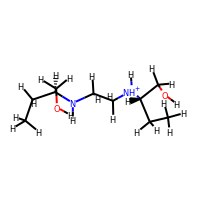
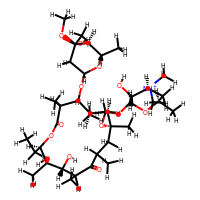

In [14]:
sourcedf = pd.merge(sourcedf, atc_categories_df, how='left', left_on='atc_category_MD',
                        right_on='cat_num')
sourcedf.drop(columns='atc_category_MD', inplace=True)
sourcedf.head(2)

# 3. Adding noise

In [15]:
randcols = []
for i in range(5000):
    name = 'rand_'+str(i+1)
    randcols.append(name)

In [16]:
randcols = [str('rand%0.4d'%(int(x)+1)) for x in range(5000)]

In [17]:
np.random.seed(1987)
randDF = pd.DataFrame(np.random.randint(2,size=(sourcedf.shape[0],5000)), columns=randcols)

In [18]:
randDF.shape, sourcedf.shape

((252, 5000), (252, 68))

In [19]:
randDF.head(2)

rand0001  rand0002  rand0003  rand0004  rand0005  rand0006  rand0007  rand0008  rand0009  rand0010  rand0011  rand0012  rand0013  rand0014  rand0015  rand0016  rand0017  rand0018  rand0019  rand0020  rand0021  rand0022  rand0023  rand0024  rand0025  rand0026  rand0027  rand0028  rand0029  rand0030  rand0031  rand0032  rand0033  rand0034  rand0035  rand0036  rand0037  rand0038  rand0039  rand0040  rand0041  rand0042  rand0043  rand0044  rand0045  rand0046  rand0047  rand0048  rand0049  rand0050  rand0051  rand0052  rand0053  rand0054  rand0055  rand0056  rand0057  rand0058  rand0059  rand0060  rand0061  rand0062  rand0063  rand0064  rand0065  rand0066  rand0067  rand0068  rand0069  rand0070  rand0071  rand0072  rand0073  rand0074  rand0075  rand0076  rand0077  rand0078  rand0079  rand0080  rand0081  rand0082  rand0083  rand0084  rand0085  rand0086  rand0087  rand0088  rand0089  rand0090  rand0091  rand0092  rand0093  rand0094  rand0095  rand0096  rand0097  rand0098  rand0099  rand0100  rand0101  rand0102  rand0103  rand0104  rand0105  rand0106  rand0107  rand0108  rand0109  rand0110  rand0111  rand0112  rand0113  rand0114  rand0115  rand0116  rand0117  rand0118  rand0119  rand0120  rand0121  rand0122  rand0123  rand0124  rand0125  rand0126  rand0127  rand0128  rand0129  rand0130  rand0131  rand0132  rand0133  rand0134  rand0135  rand0136  rand0137  rand0138  rand0139  rand0140  rand0141  rand0142  rand0143  rand0144  rand0145  rand0146  rand0147  rand0148  rand0149  rand0150  rand0151  rand0152  rand0153  rand0154  rand0155  rand0156  rand0157  rand0158  rand0159  rand0160  rand0161  rand0162  rand0163  rand0164  rand0165  rand0166  rand0167  rand0168  rand0169  rand0170  rand0171  rand0172  rand0173  rand0174  rand0175  rand0176  rand0177  rand0178  rand0179  rand0180  rand0181  rand0182  rand0183  rand0184  rand0185  rand0186  rand0187  rand0188  rand0189  rand0190  rand0191  rand0192  rand0193  rand0194  rand0195  rand0196  rand0197  rand0198  rand0199  rand0200  rand0201  rand0202  rand0203  rand0204  rand0205  rand0206  rand0207  rand0208  rand0209  rand0210  rand0211  rand0212  rand0213  rand0214  rand0215  rand0216  rand0217  rand0218  rand0219  rand0220  rand0221  rand0222  rand0223  rand0224  rand0225  rand0226  rand0227  rand0228  rand0229  rand0230  rand0231  rand0232  rand0233  rand0234  rand0235  rand0236  rand0237  rand0238  rand0239  rand0240  rand0241  rand0242  rand0243  rand0244  rand0245  rand0246  rand0247  rand0248  rand0249  rand0250  rand0251  rand0252  rand0253  rand0254  rand0255  rand0256  rand0257  rand0258  rand0259  rand0260  rand0261  rand0262  rand0263  rand0264  rand0265  rand0266  rand0267  rand0268  rand0269  rand0270  rand0271  rand0272  rand0273  rand0274  rand0275  rand0276  rand0277  rand0278  rand0279  rand0280  rand0281  rand0282  rand0283  rand0284  rand0285  rand0286  rand0287  rand0288  rand0289  rand0290  rand0291  rand0292  rand0293  rand0294  rand0295  rand0296  rand0297  rand0298  rand0299  rand0300  rand0301  rand0302  rand0303  rand0304  rand0305  rand0306  rand0307  rand0308  rand0309  rand0310  rand0311  rand0312  rand0313  rand0314  rand0315  rand0316  rand0317  rand0318  rand0319  rand0320  rand0321  rand0322  rand0323  rand0324  rand0325  rand0326  rand0327  rand0328  rand0329  rand0330  rand0331  rand0332  rand0333  rand0334  rand0335  rand0336  rand0337  rand0338  rand0339  rand0340  rand0341  rand0342  rand0343  rand0344  rand0345  rand0346  rand0347  rand0348  rand0349  rand0350  rand0351  rand0352  rand0353  rand0354  rand0355  rand0356  rand0357  rand0358  rand0359  rand0360  rand0361  rand0362  rand0363  rand0364  rand0365  rand0366  rand0367  rand0368  rand0369  rand0370  rand0371  rand0372  rand0373  rand0374  rand0375  rand0376  rand0377  rand0378  rand0379  rand0380  rand0381  rand0382  rand0383  rand0384  rand0385  rand0386  rand0387  rand0388  rand0389  rand0390  rand0391  rand0392  rand0393  rand0394  rand0395  rand0396  rand0397  rand0398  rand0399  rand0400  

vDILI  similarity LTKB_ID COMPOUND_NAME    MOL_FORMULA     CASN DRUGBANK_ID VERIFIED_DILI_CONCERN       DILI_CONCERN             LABEL_SECTION SEVERITY_CLASS                     DILI_DESCRIPTION GREENE_ANNOTATION XU_ANNOTATION OBRIEN_ANNOTATION SUZUKI_ANNOTATION GUO_ANNOTATION SAKATIS_ANNOTATION VER_DISP  siderID_FLAT              siderID_STEREO  sider_DILI_class sider_names atc_codes   atc_names               clust1_description  clust2_description                   clust3_description                         clust4_description cluster1 cluster2 cluster3 cluster4                1st_level                            2nd_level                                                                            3rd_level                             4th_level MedDRA_concept_type        UMLSID_LABEL       UMLSID_medDRA                                                                                                                                  parent_smiles                                                                                             parent_nonstd_inchi          parent_nonstd_inkey                                                                            parent_std_inchi             parent_std_inkey                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
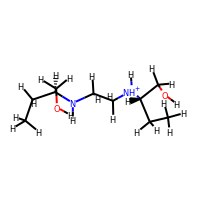

In [20]:
sourcedf = sourcedf.join(randDF)
sourcedf.head(1)

# 3. Descriptors

## 3.1. BioFingerprints

In [21]:
biocols = sourcedf.loc[:,'Hepatitis':'Ascites'].columns
biocols

Index(['Hepatitis', 'Jaundice', 'Hepatobiliary disease', 'Hepatic failure', 'Hepatic function abnormal', 'Hepatocellular injury', 'Jaundice cholestatic', 'Hyperbilirubinaemia', 'Liver injury', 'Cholestasis', 'Hepatotoxicity', 'Hepatomegaly', 'Liver disorder', 'Hepatic necrosis', 'Cholelithiasis', 'Cholecystitis', 'Foetor hepaticus', 'Hepatitis cholestatic', 'Ascites'], dtype='object')

## 3.2. Fingeprints

In [22]:
def calc_fp( mols, radius, features ):

    '''
    Info
    ----
    This function allows one to calculate morgan fingerprints from a list of molecules
    
    Parameters
    ----------
    
    radius: int
        e.g. radius = 4 ## define morgan fingerprint radius 
    mols: RDKit molecule
        e.g. mols = df.mol3DProt ## dataframe column containing molecules
    
    Return
    ------
    
    morgan fingerprints array
    
    Example
    -------
    
    mfp = calc_fp_arr( mols , radius)

    Attention
    ---------
    
    If this function doesn't work, try to update your conda environment
    
    '''

    fplist = []
    for mol in mols:
        arr = np.zeros( (1,) )
        fp = AllChem.GetMorganFingerprintAsBitVect( mol, int(radius),useFeatures=True)
        DataStructs.ConvertToNumpyArray( fp, arr )
        fplist.append( arr )
    fp_df = pd.DataFrame(fplist)
    cols = [str('MorganFP%0.4d'%(int(x)+1)) for x in range(fp_df.shape[1])]
    fp_df.columns = cols 
    return (fp_df)

In [23]:
source_fp_df = calc_fp(sourcedf.mol3DProt,3,True)
source_fp_df.reset_index(drop=True, inplace =True)
source_fp_df = sourcedf[['parent_nonstd_inkey', 'mol3DProt',
                         'cat_label', 'cat_description', 'vDILI', 'cat_num']].join(source_fp_df)
source_fp_df = source_fp_df.join(randDF)

parent_nonstd_inkey                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
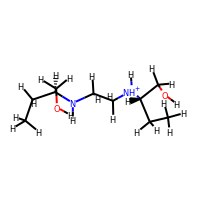
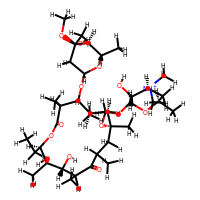

In [24]:
source_fp_df.head(2)

In [301]:
source_fp_df[source_fp_df.columns.drop(['mol3DProt'])].to_csv('mostdili_simca.csv', sep='|', index=False)

# 5. Similarity metrics analysis.

## 5.1. Functions

In [32]:
def get_similarity(df, sourceID, targetID, coefsdf, rdlist):
    
    ## Similarity distance functions
    simt = lambda a, b: (1-(distance.jaccard(a,b)/dmax))
    sime = lambda a, b: (1-(distance.euclidean(a,b)/dmax))
    simc = lambda a, b: (1-(distance.cosine(a,b)/dmax))
    simm = lambda a, b: (1-(distance.cityblock(a,b)/dmax))
#     sims = lambda a, b: (1-(distance.sokalmichener(a,b)/dmax))
    
    sims = [simt, sime, simc, simm]
    simsname = ['jaccard', 'euclidean', 'cosine', 'cityblock']
    simDF = pd.DataFrame([])
    for i,j in zip(sims, simsname):
        ydist = distance.pdist(np.array(df[dcols].astype(int)), metric=j)
        dmax = np.percentile(ydist,95)
        tdf = df[dcols].astype(int).transpose().reset_index(drop=True)
        tdf.columns = list(df[sourceID])

        # ## Correlation matrix
        corrdf = tdf.corr(method=i)
        scorrdf = corrdf.stack().reset_index()
        scorrdf.columns = [sourceID+'_source', targetID+'_target', j]
        if j == 'jaccard':
            simDF = simDF.append(scorrdf)
        else:
            simDF.loc[:,j] = scorrdf.loc[:,j]
        for rdnum in tqdm(rdlist):
            if rdnum == 0:
                continue
            ydist = distance.pdist(np.array(df[dcols].astype(int)), metric=j)
            dmax = np.percentile(ydist,95)
            rdcols = sourcedf.loc[:,'rand0001':str('rand%0.4d'%(rdnum))].columns
            tdf = df[list(dcols)+list(rdcols)].astype(int).transpose().reset_index(drop=True)
            tdf.columns = list(df[sourceID])

            # ## Correlation matrix
            corrdf = tdf.corr(method=i)
            scorrdf = corrdf.stack().reset_index()
            scorrdf.columns = [sourceID+'_source', targetID+'_target', j+str('%0.4d'%(rdnum))]
            simDF.loc[:,j+str('%0.4d'%(rdnum))] = scorrdf.loc[:,j+str('%0.4d'%(rdnum))]
    return(simDF)

## 5.2. Calculate Fingerprints Similarity between reference and test set.

In [25]:
dcols = source_fp_df.loc[:,'MorganFP0001':'MorganFP2048'].columns

In [30]:
rd1 = list(np.arange(0, 350, 50))
rdlist = rd1+[400,500,1000,5000]
rdlist

[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 5000]

In [34]:
df = source_fp_df.copy()
sourceID = 'parent_nonstd_inkey'
targetID = 'parent_nonstd_inkey'
# dcols = dcols
simDF = get_similarity(df, sourceID, targetID, dcols, rand)

100%|██████████| 11/11 [00:23<00:00,  2.54s/it]


In [35]:
simDF.head(2)

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,jaccard,jaccard0050,jaccard0100,jaccard0150,jaccard0200,jaccard0250,jaccard0300,jaccard0400,jaccard0500,jaccard1000,jaccard5000,euclidean,euclidean0050,euclidean0100,euclidean0150,euclidean0200,euclidean0250,euclidean0300,euclidean0400,euclidean0500,euclidean1000,euclidean5000,cosine,cosine0050,cosine0100,cosine0150,cosine0200,cosine0250,cosine0300,cosine0400,cosine0500,cosine1000,cosine5000,cityblock,cityblock0050,cityblock0100,cityblock0150,cityblock0200,cityblock0250,cityblock0300,cityblock0400,cityblock0500,cityblock1000,cityblock5000
0,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.0000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000
1,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AGOYDEPGAOXOCK-YDSUDHQVNA-O,0.092409,0.149061,0.196927,0.197966,0.2125,0.227855,0.239777,0.246956,0.250349,0.266209,0.300028,0.170844,0.048028,-0.038328,-0.131923,-0.215139,-0.286954,-0.354968,-0.497394,-0.63936,-1.170469,-3.485219,0.174758,0.256725,0.322571,0.320597,0.339442,0.359119,0.374343,0.384318,0.3888,0.407898,0.447988,0.3125,0.09375,-0.078125,-0.28125,-0.476562,-0.65625,-0.835938,-1.242188,-1.6875,-3.710938,-19.117188


In [428]:
simcols = simDF.columns[simDF.columns.str.contains('sim')].to_list()
simcols = [s.replace('sim','') for s in simcols]
simcols = [s.replace('rand','') for s in simcols]
simcols

['jaccard',
 'jaccard0050',
 'jaccard0100',
 'jaccard0150',
 'jaccard0200',
 'jaccard0250',
 'jaccard0300',
 'jaccard0400',
 'jaccard0500',
 'jaccard1000',
 'jaccard5000',
 'euclidean',
 'euclidean0050',
 'euclidean0100',
 'euclidean0150',
 'euclidean0200',
 'euclidean0250',
 'euclidean0300',
 'euclidean0400',
 'euclidean0500',
 'euclidean1000',
 'euclidean5000',
 'cosine',
 'cosine0050',
 'cosine0100',
 'cosine0150',
 'cosine0200',
 'cosine0250',
 'cosine0300',
 'cosine0400',
 'cosine0500',
 'cosine1000',
 'cosine5000',
 'cityblock',
 'cityblock0050',
 'cityblock0100',
 'cityblock0150',
 'cityblock0200',
 'cityblock0250',
 'cityblock0300',
 'cityblock0400',
 'cityblock0500',
 'cityblock1000',
 'cityblock5000']

In [40]:
simcols = simDF.loc[:,'jaccard':].columns.to_list()

In [38]:
simDF.columns

Index(['parent_nonstd_inkey_source', 'parent_nonstd_inkey_target', 'jaccard', 'jaccard0050', 'jaccard0100', 'jaccard0150', 'jaccard0200', 'jaccard0250', 'jaccard0300', 'jaccard0400', 'jaccard0500', 'jaccard1000', 'jaccard5000', 'euclidean', 'euclidean0050', 'euclidean0100', 'euclidean0150', 'euclidean0200', 'euclidean0250', 'euclidean0300', 'euclidean0400', 'euclidean0500', 'euclidean1000', 'euclidean5000', 'cosine', 'cosine0050', 'cosine0100', 'cosine0150', 'cosine0200', 'cosine0250', 'cosine0300', 'cosine0400', 'cosine0500', 'cosine1000', 'cosine5000', 'cityblock', 'cityblock0050', 'cityblock0100', 'cityblock0150', 'cityblock0200', 'cityblock0250', 'cityblock0300', 'cityblock0400', 'cityblock0500', 'cityblock1000', 'cityblock5000'], dtype='object')

In [41]:
cols = ['parent_nonstd_inkey', 'mol3DProt', 'atc_names', 'cat_label', 'cat_description', 'cat_num', 'vDILI']
df1 = sourcedf[cols].copy()
df1 = df1.add_suffix('_source')
df1 = df1.reset_index(drop=True)
df2 = sourcedf[cols].copy()
df2 = df2.add_suffix('_target')
df2 = df2.reset_index(drop=True)
df3 = pd.merge(simDF, df1, how='left', on='parent_nonstd_inkey_source',left_index=False, right_index=False)
sim_infodf = pd.merge(df2, df3, how='left', on='parent_nonstd_inkey_target',left_index=False, right_index=False)
sim_infodf = sim_infodf[['parent_nonstd_inkey_source', 'parent_nonstd_inkey_target',
                         'mol3DProt_source', 'mol3DProt_target', 
                         'cat_label_source', 'cat_label_target',
                         'cat_description_source', 'cat_description_target',
                         'cat_num_source', 'cat_num_target',
                         'atc_names_source','atc_names_target',
                         'vDILI_source', 'vDILI_target']+simcols]

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,mol3DProt_source,mol3DProt_target,cat_label_source,cat_label_target,cat_description_source,cat_description_target,cat_num_source,cat_num_target,atc_names_source,atc_names_target,vDILI_source,vDILI_target,jaccard,jaccard0050,jaccard0100,jaccard0150,jaccard0200,jaccard0250,jaccard0300,jaccard0400,jaccard0500,jaccard1000,jaccard5000,euclidean,euclidean0050,euclidean0100,euclidean0150,euclidean0200,euclidean0250,euclidean0300,euclidean0400,euclidean0500,euclidean1000,euclidean5000,cosine,cosine0050,cosine0100,cosine0150,cosine0200,cosine0250,cosine0300,cosine0400,cosine0500,cosine1000,cosine5000,cityblock,cityblock0050,cityblock0100,cityblock0150,cityblock0200,cityblock0250,cityblock0300,cityblock0400,cityblock0500,cityblock1000,cityblock5000
0,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,ethambutol,ethambutol,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.0000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000
1,AGOYDEPGAOXOCK-YDSUDHQVNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,clarithromycin,ethambutol,1.0,1.0,0.092409,0.149061,0.196927,0.197966,0.2125,0.227855,0.239777,0.246956,0.250349,0.266209,0.300028,0.170844,0.048028,-0.038328,-0.131923,-0.215139,-0.286954,-0.354968,-0.497394,-0.63936,-1.170469,-3.485219,0.174758,0.256725,0.322571,0.320597,0.339442,0.359119,0.374343,0.384318,0.3888,0.407898,0.447988,0.3125,0.09375,-0.078125,-0.28125,-0.476562,-0.65625,-0.835938,-1.242188,-1.6875,-3.710938,-19.117188

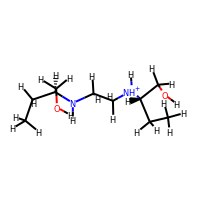
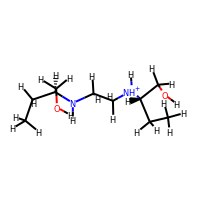
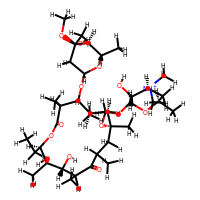
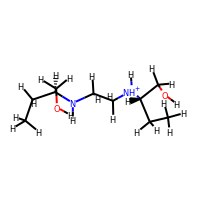

In [42]:
sim_infodf.head(2)

In [72]:
targetname = 'mostdilirank'
sim_infodf.to_pickle('results_metrics_benchmark/sim_unsupervised_'+targetname+'.pkl.gz', compression='gzip')

## 5.3. Filtering

In [8]:
targetname = 'mostdilirank'
sim_infodf = pd.read_pickle('results_metrics_benchmark/sim_unsupervised_'+targetname+'.pkl.gz', compression='gzip')

In [9]:
sim_filt_DF = sim_infodf[sim_infodf.parent_nonstd_inkey_source != sim_infodf.parent_nonstd_inkey_target]

In [10]:
sim_filt_DF.shape, sim_infodf.shape

((63252, 58), (63504, 58))

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,mol3DProt_source,mol3DProt_target,cat_label_source,cat_label_target,cat_description_source,cat_description_target,cat_num_source,cat_num_target,atc_names_source,atc_names_target,vDILI_source,vDILI_target,jaccard,jaccard0050,jaccard0100,jaccard0150,jaccard0200,jaccard0250,jaccard0300,jaccard0400,jaccard0500,jaccard1000,jaccard5000,euclidean,euclidean0050,euclidean0100,euclidean0150,euclidean0200,euclidean0250,euclidean0300,euclidean0400,euclidean0500,euclidean1000,euclidean5000,cosine,cosine0050,cosine0100,cosine0150,cosine0200,cosine0250,cosine0300,cosine0400,cosine0500,cosine1000,cosine5000,cityblock,cityblock0050,cityblock0100,cityblock0150,cityblock0200,cityblock0250,cityblock0300,cityblock0400,cityblock0500,cityblock1000,cityblock5000
1,AGOYDEPGAOXOCK-YDSUDHQVNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,clarithromycin,ethambutol,1.0,1.0,0.092409,0.149061,0.196927,0.197966,0.212500,0.227855,0.239777,0.246956,0.250349,0.266209,0.300028,0.170844,0.048028,-0.038328,-0.131923,-0.215139,-0.286954,-0.354968,-0.497394,-0.639360,-1.170469,-3.485219,0.174758,0.256725,0.322571,0.320597,0.339442,0.359119,0.374343,0.384318,0.388800,0.407898,0.447988,0.312500,0.093750,-0.078125,-0.281250,-0.476562,-0.656250,-0.835938,-1.242188,-1.687500,-3.710938,-19.117188
2,AHLBNYSZXLDEJQ-UMGWLCHRNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,A,J,ALIMENTARY TRACT AND METABOLISM,ANTIINFECTIVES FOR SYSTEMIC USE,0,6,orlistat,ethambutol,1.0,1.0,0.013889,0.104532,0.150219,0.176483,0.176674,0.203897,0.221380,0.223744,0.249809,0.271215,0.298591,0.255227,0.125000,0.015749,-0.086134,-0.189144,-0.253121,-0.316957,-0.457738,-0.566246,-1.115789,-3.493920,0.019750,0.177625,0.248458,0.286902,0.287145,0.325340,0.349053,0.352118,0.386101,0.413227,0.446280,0.445312,0.234375,0.031250,-0.179688,-0.414062,-0.570312,-0.734375,-1.125000,-1.453125,-3.476562,-19.195312
3,AJXPJJZHWIXJCJ-LBPRGKRZNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,N,J,NERVOUS SYSTEM,ANTIINFECTIVES FOR SYSTEMIC USE,9,6,mesuximide,ethambutol,0.0,1.0,0.009563,0.078526,0.169580,0.192416,0.226051,0.253609,0.252874,0.235160,0.216986,0.258540,0.292658,0.326854,0.152209,0.056271,-0.038328,-0.114535,-0.192424,-0.274755,-0.446980,-0.612936,-1.115789,-3.503471,0.012601,0.135983,0.277329,0.309822,0.355415,0.390980,0.390119,0.367156,0.343071,0.397191,0.439210,0.546875,0.281250,0.109375,-0.078125,-0.242188,-0.421875,-0.625000,-1.093750,-1.601562,-3.476562,-19.281250
4,ALOBUEHUHMBRLE-VWJBPIJRNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,C,J,CARDIOVASCULAR SYSTEM,ANTIINFECTIVES FOR SYSTEMIC USE,2,6,ibutilide,ethambutol,0.0,1.0,0.105235,0.166667,0.217048,0.250441,0.259868,0.266098,0.270833,0.249670,0.247044,0.245690,0.294615,0.276510,0.133975,0.052141,-0.030776,-0.125000,-0.205456,-0.280869,-0.460415,-0.595893,-1.181241,-3.525967,0.182639,0.274967,0.343869,0.387707,0.399593,0.406984,0.412732,0.386457,0.382840,0.381094,0.441541,0.476562,0.250000,0.101562,-0.062500,-0.265625,-0.453125,-0.640625,-1.132812,-1.546875,-3.757812,-19.484375
5,ALVHFWNGOPERPY-QUMROSFINA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,L,J,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,ANTIINFECTIVES FOR SYSTEMIC USE,7,6,sunitinib,ethambutol,1.0,1.0,0.019013,0.118590,0.183239,0.191978,0.212598,0.223225,0.238419,0.236461,0.253731,0.268086,0.302040,0.129476,0.027728,-0.038328,-0.138804,-0.224745,-0.302042,-0.375000,-0.507792,-0.620185,-1.139655,-3.490441,0.035873,0.207574,0.301476,0.312198,0.340275,0.353457,0.373518,0.370391,0.392513,0.409607,0.450381,0.242188,0.054688,-0.078125,-0.296875,-0.500000,-0.695312,-0.890625,-1.273438,-1.625000,-3.578125,-19.164062
6,AMDBBAQNWSUWGN-SGWFYVIGNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,V,J,VARIOUS,ANTIINFECTIVES FOR SYSTEMIC USE,13,6,ioversol,ethambutol,0.0,1.0,0.065171,0.117232,0.170648,0.193376,0.220976,0.239659,0.248798,0.237543,0.236866,0.262996,0.292005,0.260490,0.116117,0.011788,-0.086134,-0.169268,-0.250000,-0.325825,-0.489547,-0.622594,-1.134171,
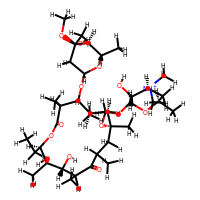
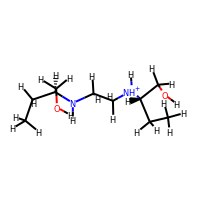
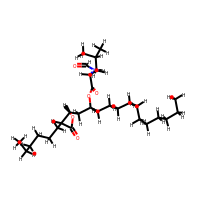
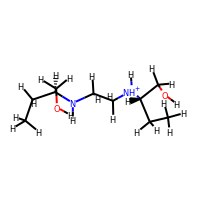
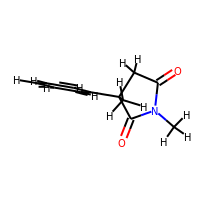
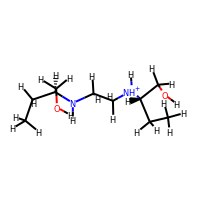
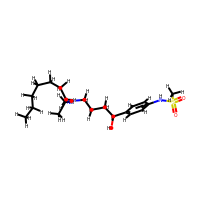
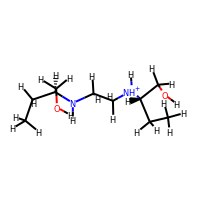
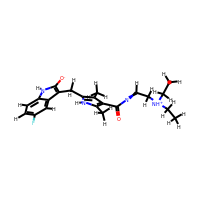
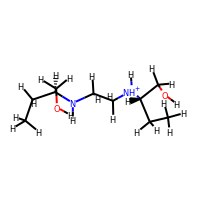
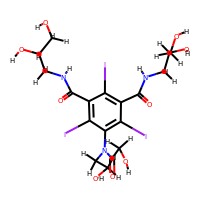
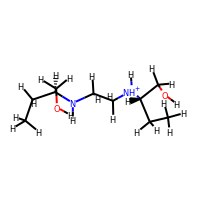
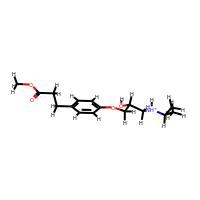
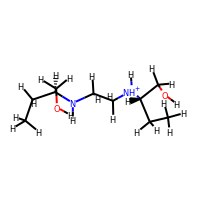
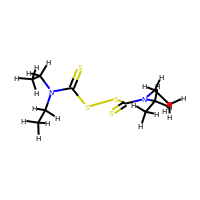
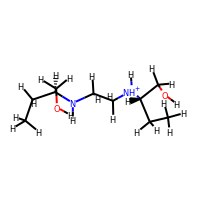
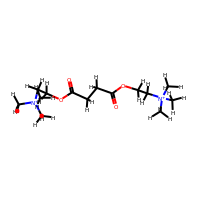
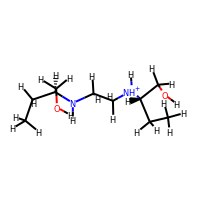
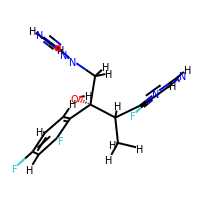
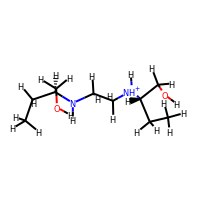

In [13]:
sim_filt_DF.head(10)

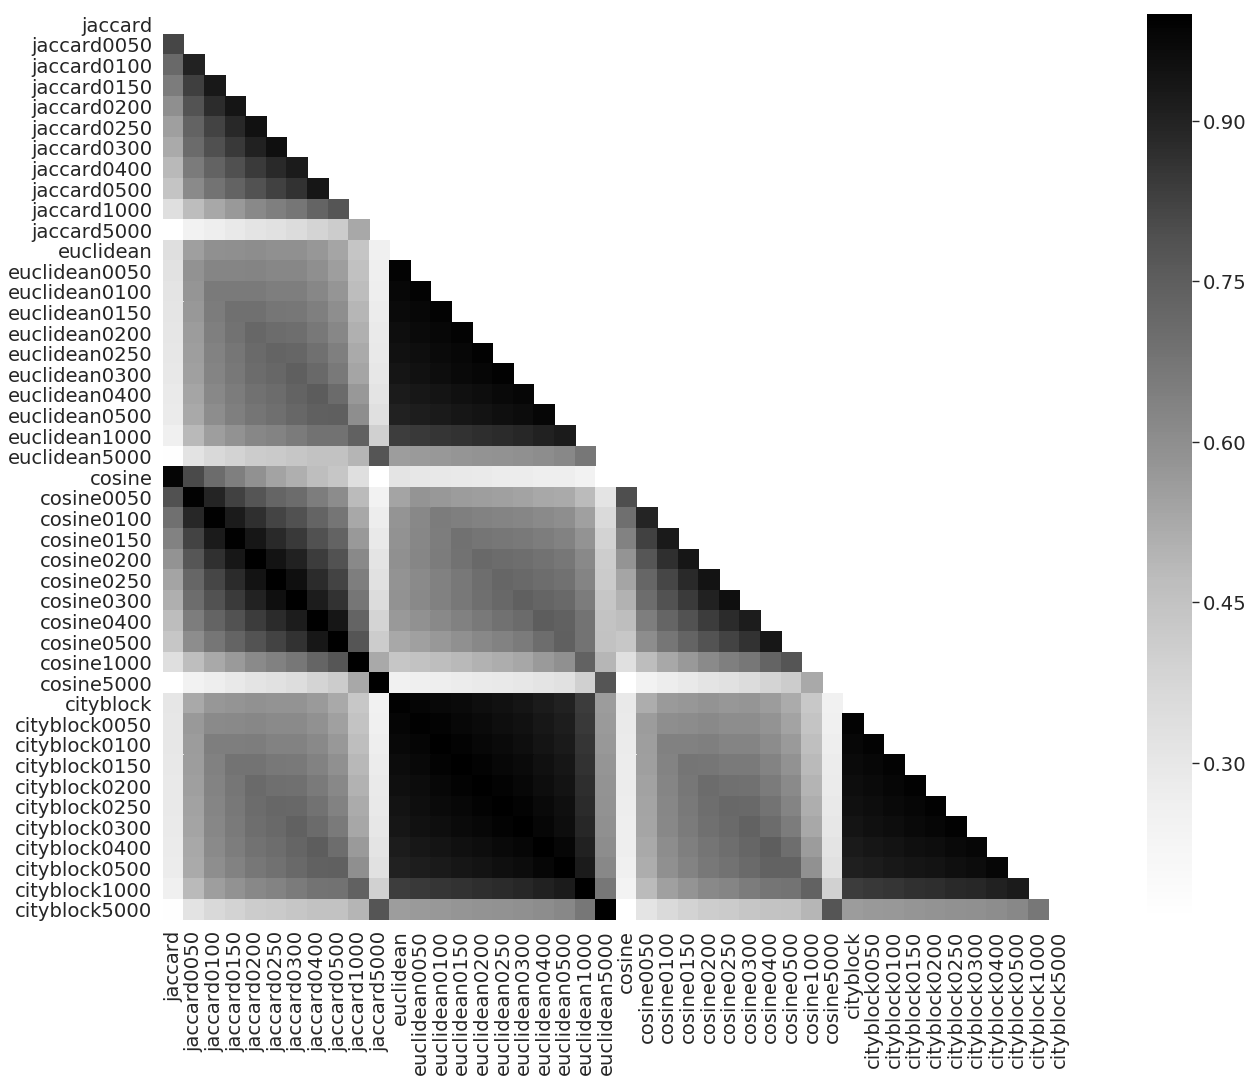

In [46]:
# Get the correlation matrix among side effects and plot it in a 
# heatmap
correlation = sim_filt_DF[simcols].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(25, 15), dpi= 80, facecolor='w', edgecolor='k')
with sns.axes_style("white"):
    heatmap = sns.heatmap(correlation, cmap='Greys', mask = mask, square=True, annot=False)
#     fig.suptitle(sourcename+' vs '+targetname, fontsize=16)
#     fig.savefig(sourcename+'_vs_'+targetname+'_corrmatrix_fingerprints.png',bbox_inches="tight")

In [47]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(df):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in df.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus

In [48]:
def getqualparameters(df, diliexp, dilipred):
    FP = df[(df[diliexp] == 0) & (df[dilipred] == 1)].shape[0]
    FN = df[(df[diliexp] == 1) & (df[dilipred] == 0)].shape[0]
    TP = df[(df[diliexp] == 1) & (df[dilipred] == 1)].shape[0]
    TN = df[(df[diliexp] == 0) & (df[dilipred] == 0)].shape[0]

    try:
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
    except:
        TPR = 0
    try:
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
    except:
        TNR = 0
    try:
        # Overall accuracy (bioisosters percentage)
        ACC = (TP+TN)/(TP+FP+FN+TN)
    except:
        ACC = 0
    try:
        # activity cliffs percentage
        actcliffs = (FP+FN)/(TP+FP+FN+TN)
    except:
        actcliffs = 0
    
    try:
        from sklearn.metrics import matthews_corrcoef
        mcc = matthews_corrcoef(df[diliexp], df[dilipred])
    except:
        mcc = 0
    return ( TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs)

In [49]:
def get_general_simquality(frame, dilitrain, dilitest, trainname, testname, simcol):
   
    simqual_trcon_df = pd.DataFrame([])
    for i in np.arange(0.0, 0.95, 0.05):
        df = frame[(frame[trainname] != frame[testname])&
                   (frame[simcol] >= i)]
#         df = frame[(frame[simcol] >= i)] ## this does not filter same test and train compounds

        df = df.replace('nan', 2)
        df = df.fillna(2)

        df[biocols] = df[biocols].astype(float)
        df[biocols] = df[biocols].astype(int)

        valdf = pd.DataFrame([],columns=['name'])
        count = 0
        for pinkey in df[testname].unique():
            count += 1
            dtest = df.loc[df[testname] == pinkey,dilitest].values[0]
            dtrain = df[df[testname].isin([pinkey])][[dilitrain]].mean(numeric_only=True)

            valdf.loc[count,'name'] = pinkey
            valdf.loc[count, dilitest] = dtest
            if dtrain.values[0] > 0.55:
                valdf.loc[count,dilitrain+'_consensus'] = int(1)
            elif dtrain.values[0] < 0.45:
                valdf.loc[count,dilitrain+'_consensus'] = int(0)
            else:
                valdf.loc[count,dilitrain+'_consensus'] = int(2) 
        try:
            TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs = getqualparameters(valdf,
                                                                              dilitest,
                                                                              dilitrain+'_consensus')
        except:
            TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs = [0,0,0,0,0,0,0,0,0]

        simqual_trcon_df = simqual_trcon_df.append([[i,len(valdf), TP, TN, FP, FN, 
                                                     TPR, TNR, mcc,
                                                     ACC, actcliffs]])
       
    simqual_trcon_df.columns = ['simcutoff','mols',
                                'TP', 'TN', 'FP', 'FN',
                                'sens', 'spec', 'mcc',
                                'bioisosters', 'actcliffs']
    floatcols = ['sens', 'spec', 'mcc', 'bioisosters', 'actcliffs']
    simqual_trcon_df[floatcols] = simqual_trcon_df[floatcols].round(2)
    intcols = ['mols','TP', 'TN', 'FP', 'FN']
    simqual_trcon_df[intcols] = simqual_trcon_df[intcols].astype(int)
    simqual_trcon_df.reset_index(drop=True,inplace=True)
    return(simqual_trcon_df)


In [50]:
def get_simqual_plot(frame):
    sns.set_style('white')
    df = frame.copy()
    df = df.set_index('simcutoff')
    cols = df.columns.drop(['mols', 'TP', 'TN', 'FP', 'FN'])
    ax = df[cols].plot(figsize=(15,10))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel("similarity cutoff")
#     ax.set_ylabel("quality parameters")

In [51]:
biocols = ['vDILI_source', 'vDILI_target']

In [52]:
df = sim_filt_DF.copy()
dilipred = 'vDILI_source'
diliexp = 'vDILI_target'
trainname = 'parent_nonstd_inkey_source'
testname = 'parent_nonstd_inkey_target'
# simfactorplotDF = pd.DataFrame(simcols, columns=['sim_metric'])
simcombDF = pd.DataFrame([])
for i in simcols:
    print ('we comence', i)
    simcol = i
    tempsimDF = get_general_simquality(df, dilipred, diliexp,
                                       trainname, testname, simcol)
    tempsimDF.loc[:,'metric'] = i
    simcombDF = pd.concat([simcombDF,tempsimDF], axis=0)
    print ('we finalize', i)

we comence jaccard


/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


we finalize jaccard
we comence jaccard0050
we finalize jaccard0050
we comence jaccard0100
we finalize jaccard0100
we comence jaccard0150
we finalize jaccard0150
we comence jaccard0200
we finalize jaccard0200
we comence jaccard0250
we finalize jaccard0250
we comence jaccard0300
we finalize jaccard0300
we comence jaccard0400
we finalize jaccard0400
we comence jaccard0500
we finalize jaccard0500
we comence jaccard1000
we finalize jaccard1000
we comence jaccard5000
we finalize jaccard5000
we comence euclidean
we finalize euclidean
we comence euclidean0050
we finalize euclidean0050
we comence euclidean0100
we finalize euclidean0100
we comence euclidean0150
we finalize euclidean0150
we comence euclidean0200
we finalize euclidean0200
we comence euclidean0250
we finalize euclidean0250
we comence euclidean0300
we finalize euclidean0300
we comence euclidean0400
we finalize euclidean0400
we comence euclidean0500
we finalize euclidean0500
we comence euclidean1000
we finalize euclidean1000
we comen

In [53]:
simcombDF.reset_index(drop=True, inplace=True)

In [74]:
simcombDF.to_pickle('results_metrics_benchmark/sim_unsupervised_quality_table.pkl')

In [5]:
simcombDF = pd.read_pickle('results_metrics_benchmark/sim_unsupervised_quality_table.pkl')

In [6]:
simcombDF.head(20)

,simcutoff,mols,TP,TN,FP,FN,sens,spec,mcc,bioisosters,actcliffs,metric
0,0.00,252,0,151,1,100,0.00,0.99,-0.05,0.60,0.40,jaccard
1,0.05,252,4,146,2,84,0.05,0.99,0.13,0.64,0.36,jaccard
2,0.10,252,12,135,1,76,0.14,0.99,0.16,0.66,0.34,jaccard
3,0.15,252,25,128,11,62,0.29,0.92,0.22,0.68,0.32,jaccard
4,0.20,227,44,127,12,30,0.59,0.91,0.49,0.80,0.20,jaccard
5,0.25,177,37,106,4,16,0.70,0.96,0.60,0.88,0.12,jaccard
6,0.30,133,25,90,4,6,0.81,0.96,0.68,0.92,0.08,jaccard
7,0.35,99,18,69,2,7,0.72,0.97,0.68,0.91,0.09,jaccard
8,0.40,72,17,50,1,3,0.85,0.98,0.83,0.94,0.06,jaccard
9,0.45,56,10,44,0,1,0.91,1.00,0.89,0.98,0.02,jaccard


# ALL Metrics without noise

In [14]:
simcols = sim_filt_DF.loc[:, 'jaccard':].columns[~sim_filt_DF.loc[:, 'jaccard':].columns.str.contains('0')]

In [15]:
simcols

Index(['jaccard', 'euclidean', 'cosine', 'cityblock'], dtype='object')

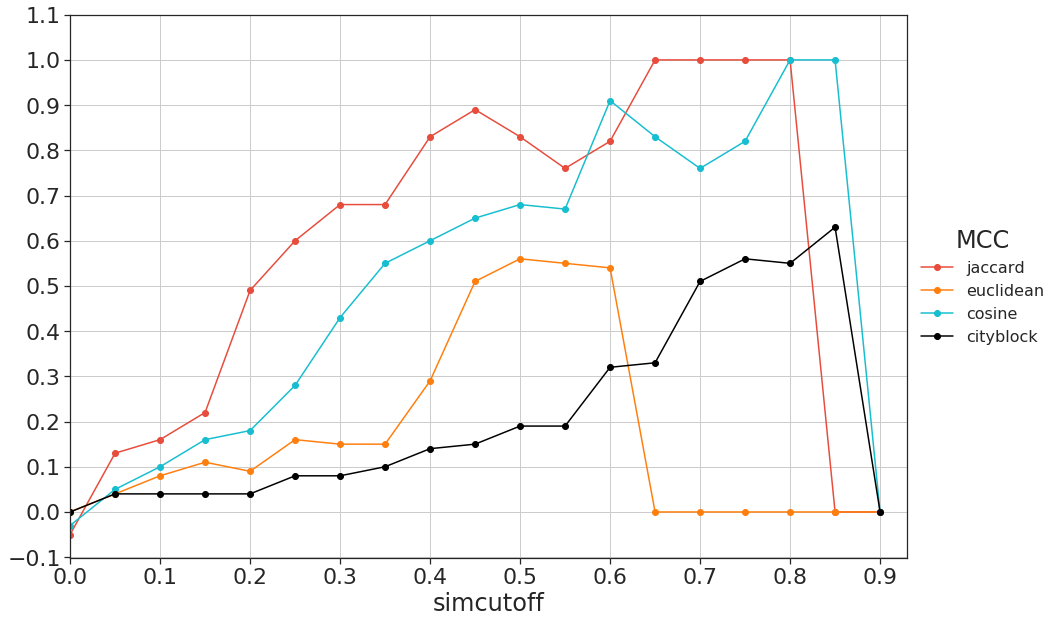

In [28]:
df = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains(str(0))])]
df = df.set_index('simcutoff')
cols = ['mcc','metric']
df = df[cols]
sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)
for i in df.metric.unique():
    tempdf = df[df.metric == i]
    sns.set_style("ticks")
    if i == 'cityblock':
        ax = tempdf['mcc'].plot(figsize=(15,10),style="-o", color='black')
    else:   
        ax = tempdf['mcc'].plot(figsize=(15,10),style="-o")
    ax.legend(labels = df.metric.unique(),loc='center left',
              bbox_to_anchor=(1.0, 0.5), title='MCC', frameon=False, fontsize=16)
    ax.set_xlim(0,0.93)
    ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
    ax.yaxis.set_ticks(np.arange(-0.1, 1.1, step=0.1))
    ax.grid(axis='both')

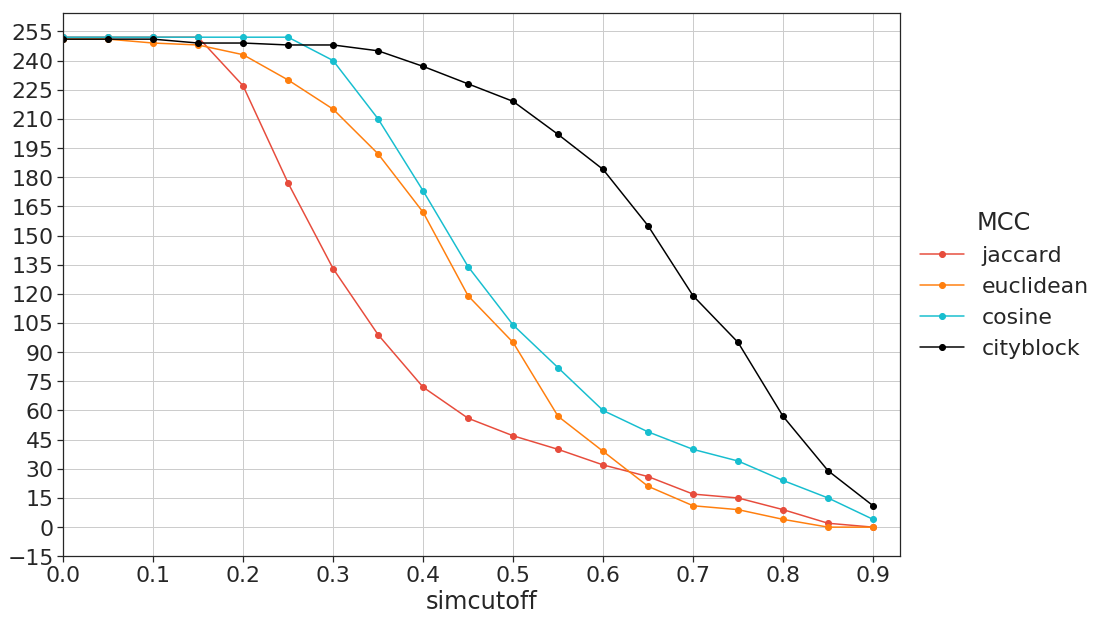

In [29]:
df = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains('0')])]
df = df.set_index('simcutoff')
cols = ['mols','metric']
df = df[cols]
sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)
for i in df.metric.unique():
    tempdf = df[df.metric == i]
    sns.set_style("ticks")
    if i == 'cityblock':
        ax = tempdf['mols'].plot(figsize=(15,10),style="-o", color='black')
    else:   
        ax = tempdf['mols'].plot(figsize=(15,10),style="-o")
    ax.legend(labels = df.metric.unique(),loc='center left',
              bbox_to_anchor=(1.0, 0.5), title='MCC', frameon=False)
    ax.set_xlim(0,0.93)
    ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
    ax.yaxis.set_ticks(np.arange(-15, 260, step=15))
    ax.grid(axis='both')

# ALL Metrics with/without noise

In [18]:
rd1 = list(np.arange(0, 350, 50))
rdlist = rd1+[400,500,1000,5000]
rdlist

[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 5000]

In [30]:
# sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)

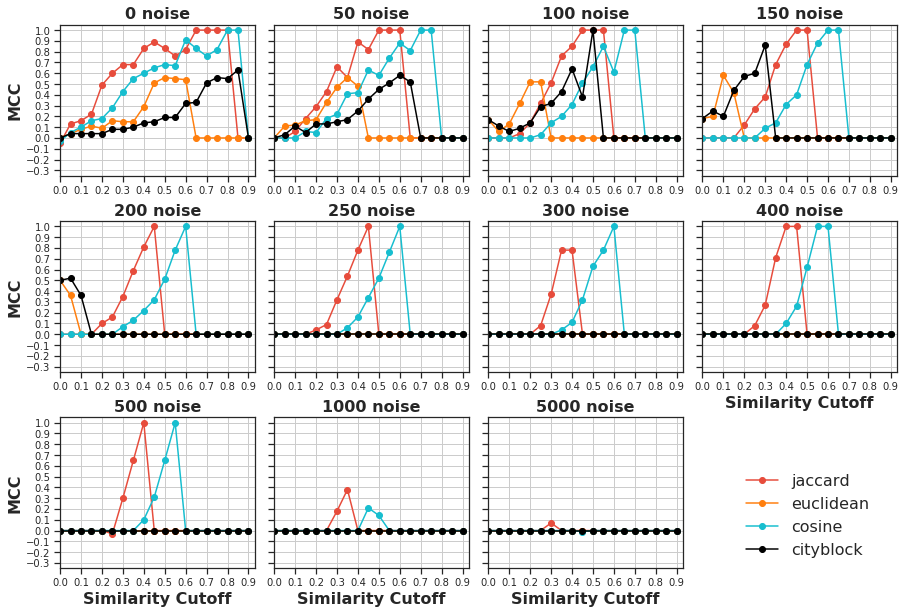

In [41]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3,4,
                                                                                         sharey=True,
                                                                                         sharex=False,
                                                                                         figsize=(15,15))
fig.subplots_adjust(hspace=0.30, wspace=0.1)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8, ax9, ax10, ax11]

sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)

for i, j in zip(axes, rdlist):
    if j == 0:
        df = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains('0')])]
    else:
        df = simcombDF[simcombDF.metric.str.endswith(str('%0.4d'%(j)))]
    df = df.set_index('simcutoff')
    cols = ['mcc','metric']
    df = df[cols]
    for k in df.metric.unique():
#             print (j,k)
        tempdf = df[df.metric == k]
        if k.startswith('cityblock'):
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o", color='black',
                                    ax=i, legend=None, fontsize=10)
        else:   
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o",
                                    ax=i, legend=None, fontsize=10)

        ax.set_title(str(j)+' noise', fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-1.1, 1.1, step=0.1))
        ax.grid(axis='both')
        if i in [ax8, ax9, ax10, ax11]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('MCC', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax11:
            ax.legend(labels = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains('0')])].metric.unique(),
                      loc='center left', bbox_to_anchor=(1.25, 0.35), frameon=False,
                      fontsize=16)
        ax.set_ylim(-0.35,1.05)
        ax.set_xlim(0,0.93)
fig.delaxes(ax12)
fig.savefig("unsupervised_results/unsupervised-metrics-MCC.png", bbox_inches="tight")

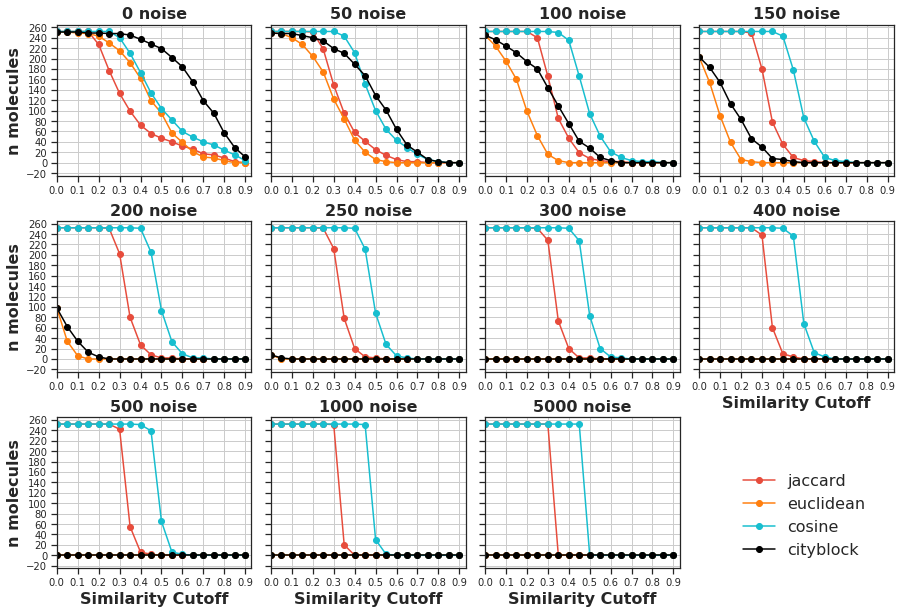

In [44]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3,4,
                                                                                         sharey=True,
                                                                                         sharex=False,
                                                                                         figsize=(15,15))
fig.subplots_adjust(hspace=0.30, wspace=0.1)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8, ax9, ax10, ax11]
for i, j in zip(axes, rdlist):
    if j == 0:
        df = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains('0')])]
    else:
        df = simcombDF[simcombDF.metric.str.endswith(str('%0.4d'%(j)))]
    df = df.set_index('simcutoff')
    cols = ['mols','metric']
    df = df[cols]
    for k in df.metric.unique():
#             print (j,k)
        tempdf = df[df.metric == k]
        if k.startswith('cityblock'):
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o", color='black',
                                    ax=i, legend=None, fontsize=10)
        else:   
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o",
                                    ax=i, legend=None, fontsize=10)

        ax.set_title(str(j)+' noise', fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-20, 280, step=20))
        ax.grid(axis='both')
        if i in [ax8, ax9, ax10, ax11]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('n molecules', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax11:
            ax.legend(labels = simcombDF[simcombDF.metric.isin(simcols[~simcols.str.contains('0')])].metric.unique(),
                      loc='center left', bbox_to_anchor=(1.25, 0.35), frameon=False,
                      fontsize=16)
        ax.set_ylim(-25,265)
        ax.set_xlim(0,0.93)
fig.delaxes(ax12)
fig.savefig("unsupervised_results/unsupervised-metrics-molecules.png", bbox_inches="tight")